In [1]:
kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 136M/149M [00:00<00:00, 277MB/s]
100% 149M/149M [00:00<00:00, 271MB/s]


In [2]:
pip install patool
import patoolib
patoolib.extract_archive("/content/brain-tumor-mri-dataset.zip")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 3.4 MB/s eta 0:00:00


INFO patool: Extracting /content/brain-tumor-mri-dataset.zip ...
INFO:patool:Extracting /content/brain-tumor-mri-dataset.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_62x1914d -- /content/brain-tumor-mri-dataset.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_62x1914d -- /content/brain-tumor-mri-dataset.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/brain-tumor-mri-dataset.zip extracted to `brain-tumor-mri-dataset' (multiple files in root).
INFO:patool:... /content/brain-tumor-mri-dataset.zip extracted to `brain-tumor-mri-dataset' (multiple files in root).


'brain-tumor-mri-dataset'

In [3]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import cv2
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import save_img

#Reading Data

In [4]:
# Initialize empty lists outside the function to accumulate images and labels
TrainImages = []
TrainLabels = []

def load_images_from_directory(main_directory, images, labels):
    # Use os.walk to iterate over all subdirectories and files
    for root, subdirs, files in os.walk(main_directory):
        # Use the folder name as the label (ignores the main directory itself)
        label = os.path.basename(root)

        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other image formats if needed
                img_path = os.path.join(root, filename)
                try:
                    image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format
                    image = image.resize((150, 150))  # Resize if needed
                    image = np.array(image)  # Convert to numpy array
                    images.append(image)  # Append the image data

                    # Append the label (subdirectory name) for each image
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

# Main directory containing subfolders of images
main_directory = '/content/brain-tumor-mri-dataset/Training'

# Load images from all subdirectories in the main directory
load_images_from_directory(main_directory, TrainImages, TrainLabels)

# Convert lists to numpy arrays if necessary
TrainLabels = np.array(TrainLabels)

print(f"Total TrainImages loaded: {len(TrainImages)}")
print(f"Unique TrainLabels: {np.unique(TrainLabels)}")


Total TrainImages loaded: 5712
Unique TrainLabels: ['glioma' 'meningioma' 'notumor' 'pituitary']


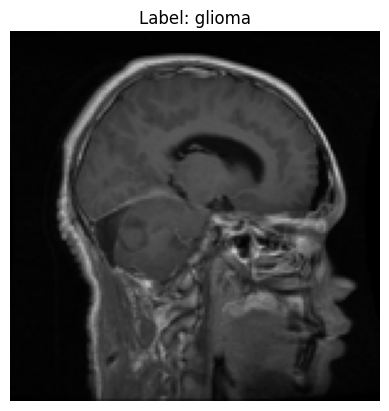

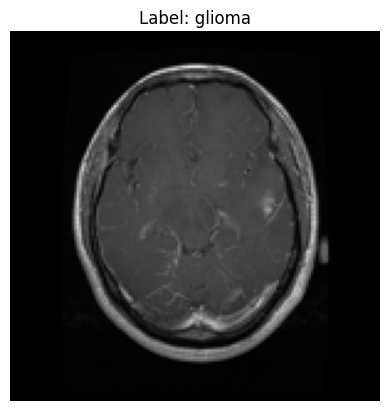

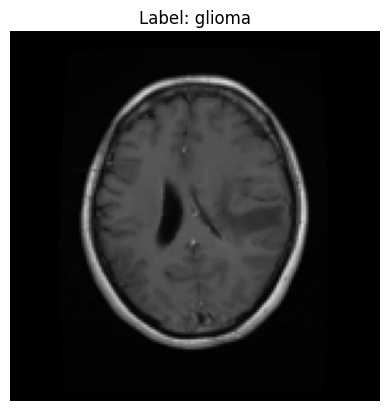

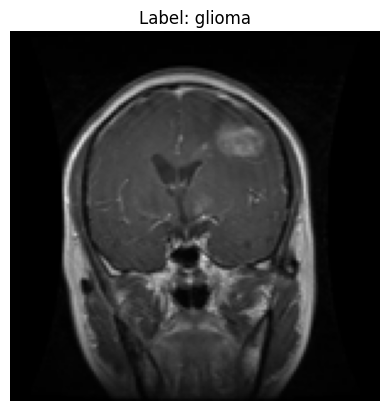

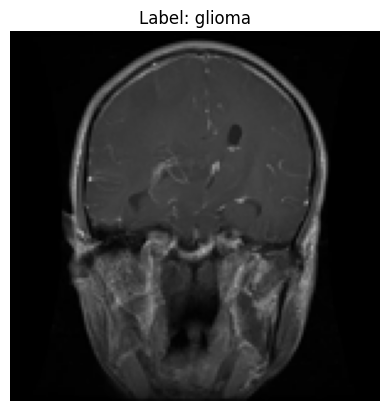

In [5]:
import matplotlib.pyplot as plt

# Display a sample of images with their labels
num_samples = 5  # Number of samples to display

for i in range(num_samples):
  plt.figure()
  plt.imshow(TrainImages[i])
  plt.title(f"Label: {TrainLabels[i]}")
  plt.axis('off')
  plt.show()


In [6]:
import os
from PIL import Image
import numpy as np

# Initialize empty lists outside the function to accumulate images and labels
TestImages = []
TestLabels = []

def load_images_from_directory(main_directory, images, labels):
    # Use os.walk to iterate over all subdirectories and files
    for root, subdirs, files in os.walk(main_directory):
        # Use the folder name as the label (ignores the main directory itself)
        label = os.path.basename(root)

        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Add other image formats if needed
                img_path = os.path.join(root, filename)
                try:
                    image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB format
                    image = image.resize((150, 150))  # Resize if needed
                    image = np.array(image)  # Convert to numpy array
                    images.append(image)  # Append the image data

                    # Append the label (subdirectory name) for each image
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

# Main directory containing subfolders of images
main_directory = '/content/brain-tumor-mri-dataset/Testing'

# Load images from all subdirectories in the main directory
load_images_from_directory(main_directory, TestImages, TestLabels)

# Convert lists to numpy arrays if necessary
TestLabels = np.array(TestLabels)

print(f"Total TestImages loaded: {len(TestImages)}")
print(f"Unique TestLabels: {np.unique(TestLabels)}")


Total TestImages loaded: 1311
Unique TestLabels: ['glioma' 'meningioma' 'notumor' 'pituitary']


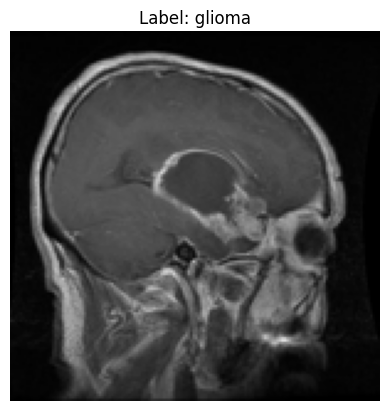

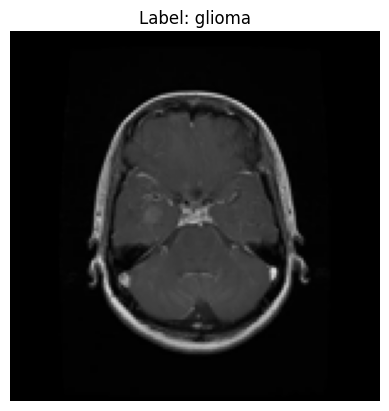

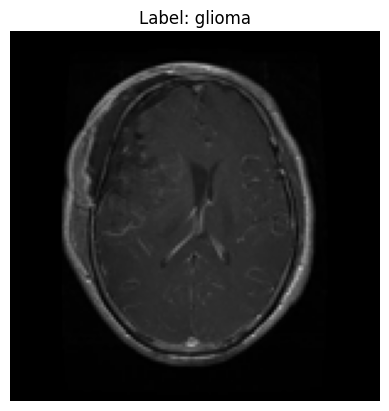

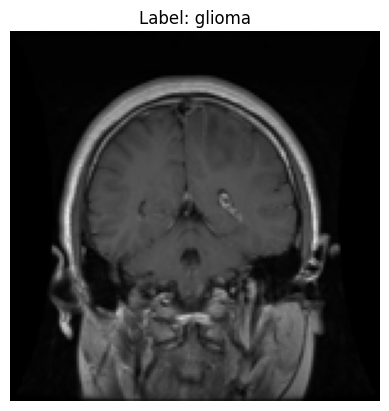

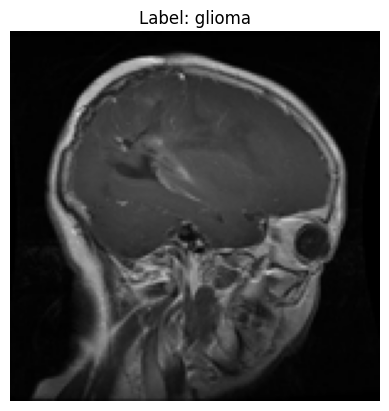

In [7]:
import matplotlib.pyplot as plt

# Display a sample of images with their labels
num_samples = 5  # Number of samples to display

for i in range(num_samples):
  plt.figure()
  plt.imshow(TestImages[i])
  plt.title(f"Label: {TestLabels[i]}")
  plt.axis('off')
  plt.show()


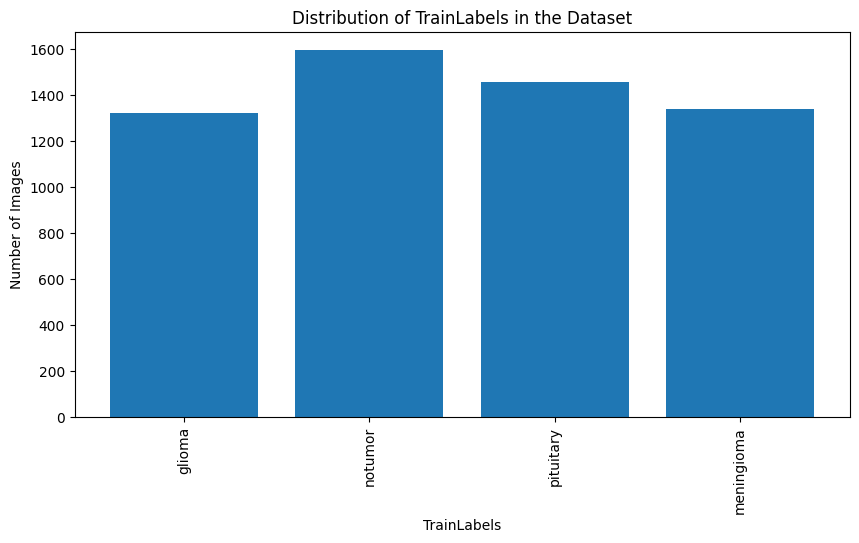

In [8]:
#visualize the TrainLabels distribution

import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = {}
for label in TrainLabels:
  if label not in label_counts:
    label_counts[label] = 0
  label_counts[label] += 1

# Extract TrainLabels and counts for plotting
label_names = list(label_counts.keys())
label_counts = list(label_counts.values())

# Create a bar chart to visualize the label distribution
plt.figure(figsize=(10, 5))
plt.bar(label_names, label_counts)
plt.xlabel("TrainLabels")
plt.ylabel("Number of Images")
plt.title("Distribution of TrainLabels in the Dataset")
plt.xticks(rotation=90)  # Rotate x-axis TrainLabels for readability if needed
plt.show()


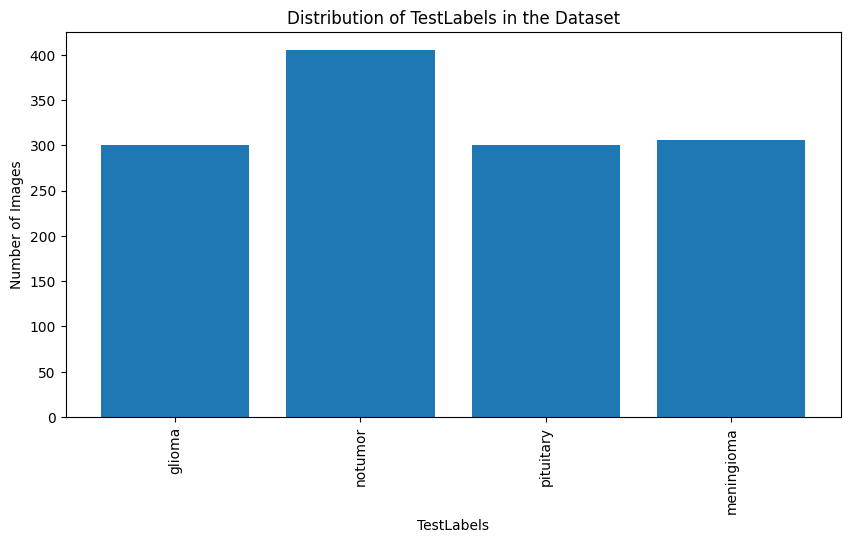

In [9]:
#visualize the TestLabels distribution

import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = {}
for label in TestLabels:
  if label not in label_counts:
    label_counts[label] = 0
  label_counts[label] += 1

# Extract TestLabels and counts for plotting
label_names = list(label_counts.keys())
label_counts = list(label_counts.values())

# Create a bar chart to visualize the label distribution
plt.figure(figsize=(10, 5))
plt.bar(label_names, label_counts)
plt.xlabel("TestLabels")
plt.ylabel("Number of Images")
plt.title("Distribution of TestLabels in the Dataset")
plt.xticks(rotation=90)  # Rotate x-axis TestLabels for readability if needed
plt.show()


In [10]:
TrainImages[0].shape

(150, 150, 3)

In [12]:
# Convert Image and Label Lists to Numpy Arrays
# Normalize the images by converting pixel values to the range [0, 1]
X = np.array(TrainImages, dtype='float32') / 255.0

# Encode the labels using LabelEncoder and convert them to categorical (one-hot encoded) labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(TrainLabels)  # Convert labels to numeric values
y = to_categorical(y, num_classes=len(np.unique(TrainLabels)))  # One-hot encode the labels


In [14]:
#Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [15]:
# Build the CNN Model for Image Classification
model = Sequential()

# Convolutional layers
# Updated input shape to match X_train shape (150, 150, 3)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# Assuming 'TrainLabels' is available and represents the target labels
model.add(Dense(len(np.unique(TrainLabels)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Add EarlyStopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs to wait before stopping if no improvement
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Add ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,          # Factor by which the learning rate will be reduced
    patience=3,          # Number of epochs to wait before reducing the learning rate
    min_lr=1e-6,         # Lower bound on the learning rate
    verbose=1
)

# Now, when you train the model, include these callbacks in the `fit` method
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,           # Maximum number of epochs to train
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]  # Include the callbacks here
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.5644 - loss: 0.9936 - val_accuracy: 0.8381 - val_loss: 0.4570 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8273 - loss: 0.4458 - val_accuracy: 0.8355 - val_loss: 0.4413 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8734 - loss: 0.3464 - val_accuracy: 0.8889 - val_loss: 0.2845 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9085 - loss: 0.2399 - val_accuracy: 0.9099 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9322 - loss: 0.1866 - val_accuracy: 0.9178 - val_loss: 0.2379 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9418 - loss: 0.1582 - val_accuracy: 0.9230 - val_loss: 0.2302 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9573 - loss:

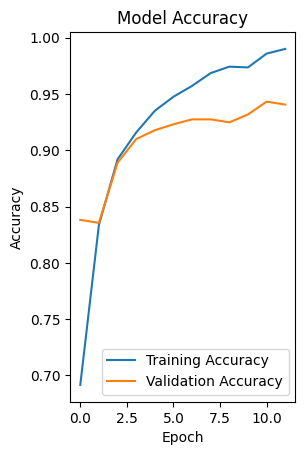

In [17]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

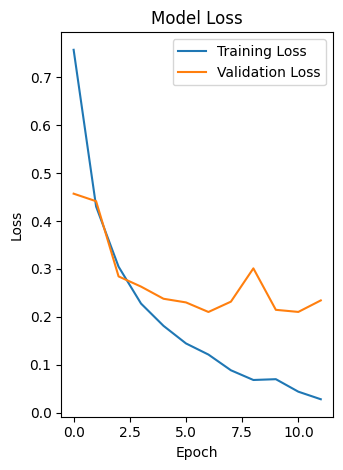

In [18]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
# Step 8: Save the Trained Model
model.save('brain_tumor_classifier_model.h5')

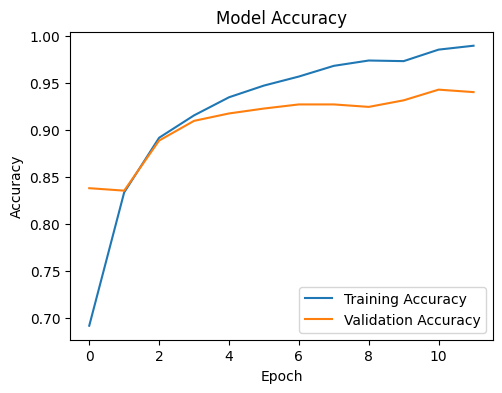

In [20]:
# prompt: visualize model accuracy

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
              precision    recall  f1-score   support

      glioma       0.93      0.89      0.91       300
  meningioma       0.88      0.79      0.83       306
     notumor       0.92      1.00      0.96       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



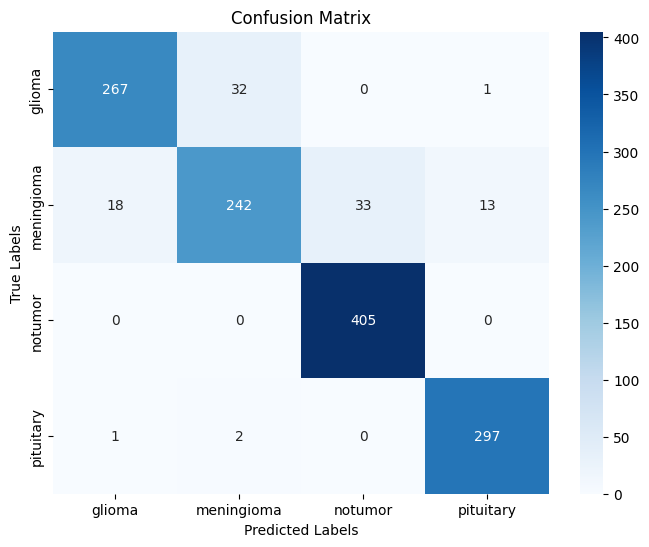

In [23]:
# prompt: visualize accuracy matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have your test data and labels as X_test and y_test
X_test = np.array(TestImages, dtype='float32') / 255.0
y_test = label_encoder.transform(TestLabels)  # Use the same label encoder used for training

# Make predictions on the test data
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [22]:
# prompt: test the model

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Step 2: Preprocess the Test Data
# Normalize the images by converting pixel values to the range [0, 1]
X_test = np.array(TestImages, dtype='float32') / 255.0

# Encode the labels using LabelEncoder and convert them to categorical (one-hot encoded) labels
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(TestLabels)  # Convert labels to numeric values
y_test = to_categorical(y_test, num_classes=len(np.unique(TestLabels)))  # One-hot encode the labels

# Step 3: Evaluate the Model on the Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 4 (Optional): Make Predictions on New Data
# You can use model.predict(new_data) to get predictions on new data.
# Make sure new_data is preprocessed in the same way as your training data.


41/41 - 1s - 34ms/step - accuracy: 0.9237 - loss: 0.2108
Test Loss: 0.2108
Test Accuracy: 0.9237
